In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import cv2

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from sklearn.metrics import classification_report, confusion_matrix

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# create a dataset and dataloader for the data
data_dir_train = pathlib.Path('../../data/skincancer_new_processed/train/images')
data_dir_test = pathlib.Path('../../data/skincancer_new_processed/test/images')

In [4]:
ground_truth_file_test = pathlib.Path('../../data/skincancer_new_processed/test_GroundTruth.csv')
ground_truth_file_train = pathlib.Path('../../data/skincancer_new_processed/train_GroundTruth.csv')

In [5]:
train_ids = [f.stem for f in data_dir_train.glob("*.png")]
test_ids = [f.stem for f in data_dir_test.glob("*.png")]

In [6]:
#train_ids

In [7]:
class Dataset_skincancer_custom(Dataset):
    def __init__(self, image_dir, ground_truth_file, ids, transform=None):
        """
        Args:
            image_dir (pathlib.Path): Directory with all the images.
            ground truth: num
            transform (callable, optional): Optional additional transform to be applied on an image/mask.
        """
        self.image_dir = image_dir
        self.ground_truth_file = ground_truth_file
        self.ids = ids
        self.transform = transform
        self.to_tensor = ToTensor()  # Define ToTensor transformation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        # Load image and mask
        image = np.array(Image.open(self.image_dir / f"{name}.png").convert("RGB"))
        image = self.to_tensor(image)
        
        # Load ground truth
        ground_truth_df = pd.read_csv(self.ground_truth_file)
        ground_truth = ground_truth_df[ground_truth_df['image_id'] == name][['melanoma', 'seborrheic_keratosis']].values
        ground_truth = torch.tensor(ground_truth, dtype=torch.float32)
        ground_truth = ground_truth.squeeze()
        #mask = np.array(mask)

        # Apply ToTensor transformation
        #image = self.to_tensor(image)
        #mask = self.to_tensor(mask)


        ## Apply additional transformations if provided
        #if self.transform:
        #    image = self.transform(image)
        #    mask = self.transform(mask)
        
        #print(image)
        #print(ground_truth)

        return image, ground_truth

In [8]:
batch_size = 8

In [9]:
# Create datasets with transformations
dataset_train = Dataset_skincancer_custom(data_dir_train, ground_truth_file_train, train_ids)
dataset_test = Dataset_skincancer_custom(data_dir_test, ground_truth_file_test, test_ids)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [10]:
for i, item in enumerate(test_loader):
    print(item)
    if i == 0:
        break

[tensor([[[[0.0314, 0.0275, 0.0353,  ..., 0.1059, 0.0706, 0.0784],
          [0.0314, 0.0196, 0.1529,  ..., 0.2392, 0.0627, 0.0784],
          [0.0275, 0.0314, 0.3412,  ..., 0.4392, 0.0863, 0.0706],
          ...,
          [0.3922, 0.3490, 0.3412,  ..., 0.4824, 0.4627, 0.4471],
          [0.3961, 0.3451, 0.3451,  ..., 0.5059, 0.4941, 0.4196],
          [0.2784, 0.3451, 0.3451,  ..., 0.4941, 0.4706, 0.2706]],

         [[0.0314, 0.0275, 0.0353,  ..., 0.1059, 0.0745, 0.0824],
          [0.0314, 0.0196, 0.1412,  ..., 0.2314, 0.0627, 0.0784],
          [0.0314, 0.0314, 0.3137,  ..., 0.4235, 0.0863, 0.0706],
          ...,
          [0.3137, 0.2471, 0.2275,  ..., 0.4588, 0.4353, 0.4235],
          [0.3529, 0.2392, 0.2275,  ..., 0.4863, 0.4745, 0.4039],
          [0.2549, 0.2431, 0.2314,  ..., 0.4706, 0.4471, 0.2588]],

         [[0.0314, 0.0314, 0.0353,  ..., 0.1137, 0.0784, 0.0902],
          [0.0314, 0.0196, 0.1412,  ..., 0.2353, 0.0706, 0.0863],
          [0.0314, 0.0353, 0.3176,  ..., 

In [11]:
for i, item in enumerate(train_loader):
    print(item)
    if i == 0:
        break

[tensor([[[[0.4392, 0.4431, 0.3020,  ..., 0.0471, 0.0471, 0.0392],
          [0.3137, 0.3725, 0.3490,  ..., 0.0392, 0.0510, 0.0549],
          [0.3020, 0.2706, 0.3804,  ..., 0.0471, 0.0627, 0.0549],
          ...,
          [0.0980, 0.3412, 0.4000,  ..., 0.3765, 0.3137, 0.2196],
          [0.0392, 0.2078, 0.3333,  ..., 0.3333, 0.2627, 0.2314],
          [0.0431, 0.0824, 0.2627,  ..., 0.3804, 0.1922, 0.2392]],

         [[0.4980, 0.5059, 0.3647,  ..., 0.0510, 0.0510, 0.0392],
          [0.3686, 0.4275, 0.3922,  ..., 0.0431, 0.0549, 0.0588],
          [0.3686, 0.3255, 0.3843,  ..., 0.0510, 0.0667, 0.0627],
          ...,
          [0.0941, 0.3098, 0.3608,  ..., 0.4078, 0.3843, 0.2745],
          [0.0392, 0.1843, 0.2980,  ..., 0.3922, 0.3294, 0.2863],
          [0.0431, 0.0745, 0.2314,  ..., 0.4510, 0.2392, 0.2863]],

         [[0.5647, 0.5725, 0.4471,  ..., 0.0588, 0.0588, 0.0471],
          [0.4353, 0.5020, 0.4549,  ..., 0.0510, 0.0627, 0.0667],
          [0.4471, 0.4078, 0.4196,  ..., 

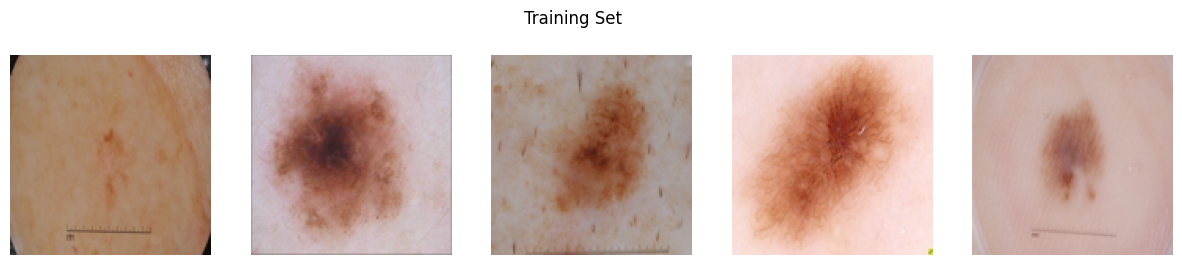

In [12]:
# plot the first 5 images in the training set, the first 5 images in the test set
def plot_images(loader, title):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, (image, ground_truth) in enumerate(loader):
        if i == 5:
            break
        axs[i].imshow(image[i].permute(1, 2, 0))
        axs[i].axis("off")
    fig.suptitle(title)
    plt.show()

plot_images(train_loader, "Training Set")
#plot_images(test_loader, "Test Set")

In [13]:
# create a custom convolutional neural network model for the classification task

class CustomCNN(torch.nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu1 = torch.nn.LeakyReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = torch.nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.relu2 = torch.nn.LeakyReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = torch.nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.relu3 = torch.nn.LeakyReLU()
        self.conv4 = torch.nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.relu4 = torch.nn.LeakyReLU()
        self.conv5 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu5 = torch.nn.LeakyReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(256 * 3 * 3, 4096)
        self.relu6 = torch.nn.LeakyReLU()
        self.fc2 = torch.nn.Linear(4096, 4096)
        self.relu7 = torch.nn.LeakyReLU()
        self.fc3 = torch.nn.Linear(4096, 2)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.pool3(self.relu5(self.conv5(x)))
        x = self.flatten(x)
        x = self.relu6(self.fc1(x))
        x = self.relu7(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        # apply softmax to get class probabilities
        #x = torch.nn.functional.softmax(x, dim=1)
        return x
    
# create model
model = CustomCNN().to(device)
model.load_state_dict(torch.load('./customCNN_new_skincancer.pth'))
model.to(device)

/tmp/ipykernel_406439/3999995024.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./customCNN_new_skincancer.pth'))


CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): LeakyReLU(negative_slope=0.01)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2304, out_features=4096, bias=True)
  (relu6): LeakyRe

In [14]:
# test model with a random input
x = torch.randn(1, 3, 128, 128).to(device)
y = model(x)
print(y)

tensor([[0.5027, 0.4994]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [15]:
# test model with the first batch of the training data
for i, (image, ground_truth) in enumerate(train_loader):
    if i == 1:
        break
    image = image.to(device)
    ground_truth = ground_truth.to(device)
    output = model(image)
    # convert output to tensor with 1 on the predicted class and 0 on the other classes
    _, predicted_max = torch.max(output, 1)
    print(output)
    output = torch.zeros_like(output)
    output[torch.arange(output.size(0)), predicted_max] = 1
    print(output)
    print(ground_truth)

tensor([[0.5023, 0.4981],
        [0.5024, 0.4983],
        [0.5023, 0.4983],
        [0.5024, 0.4983],
        [0.5024, 0.4983],
        [0.5024, 0.4983],
        [0.5024, 0.4984],
        [0.5023, 0.4982]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], device='cuda:0')
tensor([[0., 1.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')


In [16]:
#criterion = torch.nn.BCELoss()
#criterion = torch.nn.L1Loss() # In this particular case, we are using L1 loss instead of BCE loss: accuracy + 10% with L1 loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# train the model
model.train()
for epoch in range(200):
    #if epoch == 1:
    #    break
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = len(train_loader)
    for images, ground_truth in train_loader:
        images, ground_truth = images.to(device), ground_truth.to(device)
        #ground_truth = ground_truth.float()

        optimizer.zero_grad()
        outputs = model(images)
        #loss = criterion(outputs, ground_truth)
        loss = ((outputs - (ground_truth ))**2).mean() #* 3.18
        #print("outputs")
        #print(outputs)
        predictions = (outputs > 0.5).float()
        #print("predictions")
        #print(predictions)
        #print("ground_truth")
        #print(ground_truth)

        loss.backward()
        optimizer.step()
        
        accuracy = (predictions == ground_truth).float().mean()
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss/num_batches}, Accuracy: {epoch_accuracy/num_batches}")

Epoch 1, Loss: 0.14545689984411, Accuracy: 0.838
Epoch 2, Loss: 0.13112790459394455, Accuracy: 0.843
Epoch 3, Loss: 0.13132829093933104, Accuracy: 0.843
Epoch 4, Loss: 0.13051656475663184, Accuracy: 0.843
Epoch 5, Loss: 0.13073690193891524, Accuracy: 0.843
Epoch 6, Loss: 0.1304237489029765, Accuracy: 0.843
Epoch 7, Loss: 0.1301746001727879, Accuracy: 0.843
Epoch 8, Loss: 0.12998870272561908, Accuracy: 0.843
Epoch 9, Loss: 0.12954096988216043, Accuracy: 0.843
Epoch 10, Loss: 0.12963191086798906, Accuracy: 0.843
Epoch 11, Loss: 0.12869754076004028, Accuracy: 0.843
Epoch 12, Loss: 0.1273352969251573, Accuracy: 0.843
Epoch 13, Loss: 0.12595681079104543, Accuracy: 0.843
Epoch 14, Loss: 0.12488494114950299, Accuracy: 0.843
Epoch 15, Loss: 0.12142980509996414, Accuracy: 0.8435
Epoch 16, Loss: 0.12177879248186946, Accuracy: 0.84375
Epoch 17, Loss: 0.11925314810872079, Accuracy: 0.845
Epoch 18, Loss: 0.11762035626731814, Accuracy: 0.84575
Epoch 19, Loss: 0.11538145798817277, Accuracy: 0.847
Epo

In [17]:
# evaluate the model
model.eval()
predictions = []
with torch.no_grad():
    for images, ground_truth in test_loader:
        images, ground_truth = images.to(device), ground_truth.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        predictions.append(predicted.cpu().numpy()[0])

In [18]:
df_predicted = pd.DataFrame(predictions, columns=['melanoma', 'seborrheic_keratosis'], index=test_ids)
df_predicted['none'] = df_predicted['melanoma'] + df_predicted['seborrheic_keratosis']
df_predicted['none'] = df_predicted['none'].apply(lambda x: 1.0 if x == 0.0 else 0.0)
# sort by index
df_predicted = df_predicted.sort_index()
df_predicted

,melanoma,seborrheic_keratosis,none
ISIC_0012086,0.0,1.0,0.0
ISIC_0012092,0.0,0.0,1.0
ISIC_0012095,0.0,0.0,1.0
ISIC_0012134,0.0,1.0,0.0
ISIC_0012136,0.0,0.0,1.0
...,...,...,...
ISIC_0016068,1.0,0.0,0.0
ISIC_0016069,0.0,0.0,1.0
ISIC_0016070,0.0,0.0,1.0
ISIC_0016071,0.0,0.0,1.0


In [19]:
df_predicted.sum()

melanoma                 90.0
seborrheic_keratosis     95.0
none                    416.0
dtype: float64

In [20]:
df_ground_truth = pd.read_csv(ground_truth_file_test, index_col='image_id')
df_ground_truth['none'] = df_ground_truth['melanoma'] + df_ground_truth['seborrheic_keratosis']
df_ground_truth['none'] = df_ground_truth['none'].apply(lambda x: 1.0 if x == 0.0 else 0.0)
df_ground_truth

,melanoma,seborrheic_keratosis,none
image_id,,,
ISIC_0012086,0.0,1.0,0.0
ISIC_0012092,0.0,0.0,1.0
ISIC_0012095,0.0,0.0,1.0
ISIC_0012134,0.0,1.0,0.0
ISIC_0012136,0.0,1.0,0.0
...,...,...,...
ISIC_0016068,0.0,0.0,1.0
ISIC_0016069,0.0,0.0,1.0
ISIC_0016070,0.0,0.0,1.0


In [21]:
df_ground_truth.sum()

melanoma                117.0
seborrheic_keratosis     90.0
none                    393.0
dtype: float64

In [22]:
# print mean absolute error
print("Mean Absolute Error:")
print((df_predicted - df_ground_truth).abs().mean())

Mean Absolute Error:
melanoma                0.231667
seborrheic_keratosis    0.155000
none                    0.271667
dtype: float64


In [23]:
labels_predicted = df_predicted[['melanoma', 'seborrheic_keratosis', 'none']].idxmax(axis=1)
labels_ground_truth = df_ground_truth[['melanoma', 'seborrheic_keratosis', 'none']].idxmax(axis=1)

In [24]:
labels_predicted

ISIC_0012086    seborrheic_keratosis
ISIC_0012092                    none
ISIC_0012095                    none
ISIC_0012134    seborrheic_keratosis
ISIC_0012136                    none
                        ...         
ISIC_0016068                melanoma
ISIC_0016069                    none
ISIC_0016070                    none
ISIC_0016071                    none
ISIC_0016072                    none
Length: 600, dtype: object

In [25]:
labels_ground_truth

image_id
ISIC_0012086    seborrheic_keratosis
ISIC_0012092                    none
ISIC_0012095                    none
ISIC_0012134    seborrheic_keratosis
ISIC_0012136    seborrheic_keratosis
                        ...         
ISIC_0016068                    none
ISIC_0016069                    none
ISIC_0016070                    none
ISIC_0016071                    none
ISIC_0016072                    none
Length: 600, dtype: object

In [26]:
# evaluate the model
print("Classification Report")
print(classification_report(labels_ground_truth, labels_predicted))

Classification Report
                      precision    recall  f1-score   support

            melanoma       0.38      0.29      0.33       117
                none       0.78      0.82      0.80       393
seborrheic_keratosis       0.49      0.51      0.50        90

            accuracy                           0.67       600
           macro avg       0.55      0.54      0.54       600
        weighted avg       0.66      0.67      0.66       600



In [27]:
cm = confusion_matrix(labels_ground_truth, labels_predicted)
cm

array([[ 34,  64,  19],
       [ 41, 323,  29],
       [ 15,  29,  46]])

In [28]:
import plotly.express as px
# plot confusion matrix
fig = px.imshow(cm, labels=dict(x="Predicted", y="True", color="Count"), x=['Melanoma', 'None', 'Seborrheic Keratosis'],
                 y=['Melanoma', 'None', 'Seborrheic Keratosis'], text_auto=True, width=600, height=600, color_continuous_scale='reds',
                   title="Confusion Matrix")
# remove colorbar
fig.update_layout(coloraxis_showscale=False)
fig.show()

In [29]:
# save the model
torch.save(model.state_dict(), "customCNN_new_skincancer.pth")

---

In [33]:
# remove the model from the GPU
model = model.cpu()
# clean GPU cache
torch.cuda.empty_cache()

In [20]:
interpretabilities_dict = {}
interpretabilities_dict['ig'] = []
interpretabilities_dict['saliency'] = []
interpretabilities_dict['deep_lift'] = []
interpretabilities_dict['label_predicted'] = []

In [21]:
model.eval()
with torch.no_grad():
    for images, ground_truth in test_loader:
        image = images.to(device)
        # get the argmax of the ground truth
        target = ground_truth.squeeze().argmax().item()
        # Integrated Gradients
        ig = IntegratedGradients(model)
        attr_ig, delta_ig = ig.attribute(image, target=target, return_convergence_delta=True, n_steps=300)
        attr_ig = attr_ig.squeeze().permute(1, 2, 0).cpu().detach().numpy()
        attr_ig = np.transpose(attr_ig, (1, 0, 2))
        attr_ig_sum_norm = np.sum(np.abs(attr_ig), axis=2)
        attr_ig_sum_norm = attr_ig_sum_norm / np.max(attr_ig_sum_norm)
        interpretabilities_dict['ig'].append(attr_ig_sum_norm)
        # Saliency
        saliency = Saliency(model)
        attr_saliency = saliency.attribute(image, target=target)
        attr_saliency = attr_saliency.squeeze().permute(1, 2, 0).cpu().detach().numpy()
        attr_saliency = np.transpose(attr_saliency, (1, 0, 2))
        attr_saliency_sum_norm = np.sum(np.abs(attr_saliency), axis=2)
        attr_saliency_sum_norm = attr_saliency_sum_norm / np.max(attr_saliency_sum_norm)
        interpretabilities_dict['saliency'].append(attr_saliency_sum_norm)
        # DeepLift
        dl = DeepLift(model)
        attr_dl = dl.attribute(image, target=target)
        attr_dl = attr_dl.squeeze().permute(1, 2, 0).cpu().detach().numpy()
        attr_dl = np.transpose(attr_dl, (1, 0, 2))
        attr_dl_sum_norm = np.sum(np.abs(attr_dl), axis=2)
        attr_dl_sum_norm = attr_dl_sum_norm / np.max(attr_dl_sum_norm)
        interpretabilities_dict['deep_lift'].append(attr_dl_sum_norm)

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/tmp/ipykernel_406439/2252025346.py:21: RuntimeWarning: invalid value encountered in divide
  attr_saliency_sum_norm = attr_saliency_sum_norm / np.max(attr_saliency_sum_norm)


In [22]:
interpretabilities_dict['deep_lift'][0].shape

(128, 128)

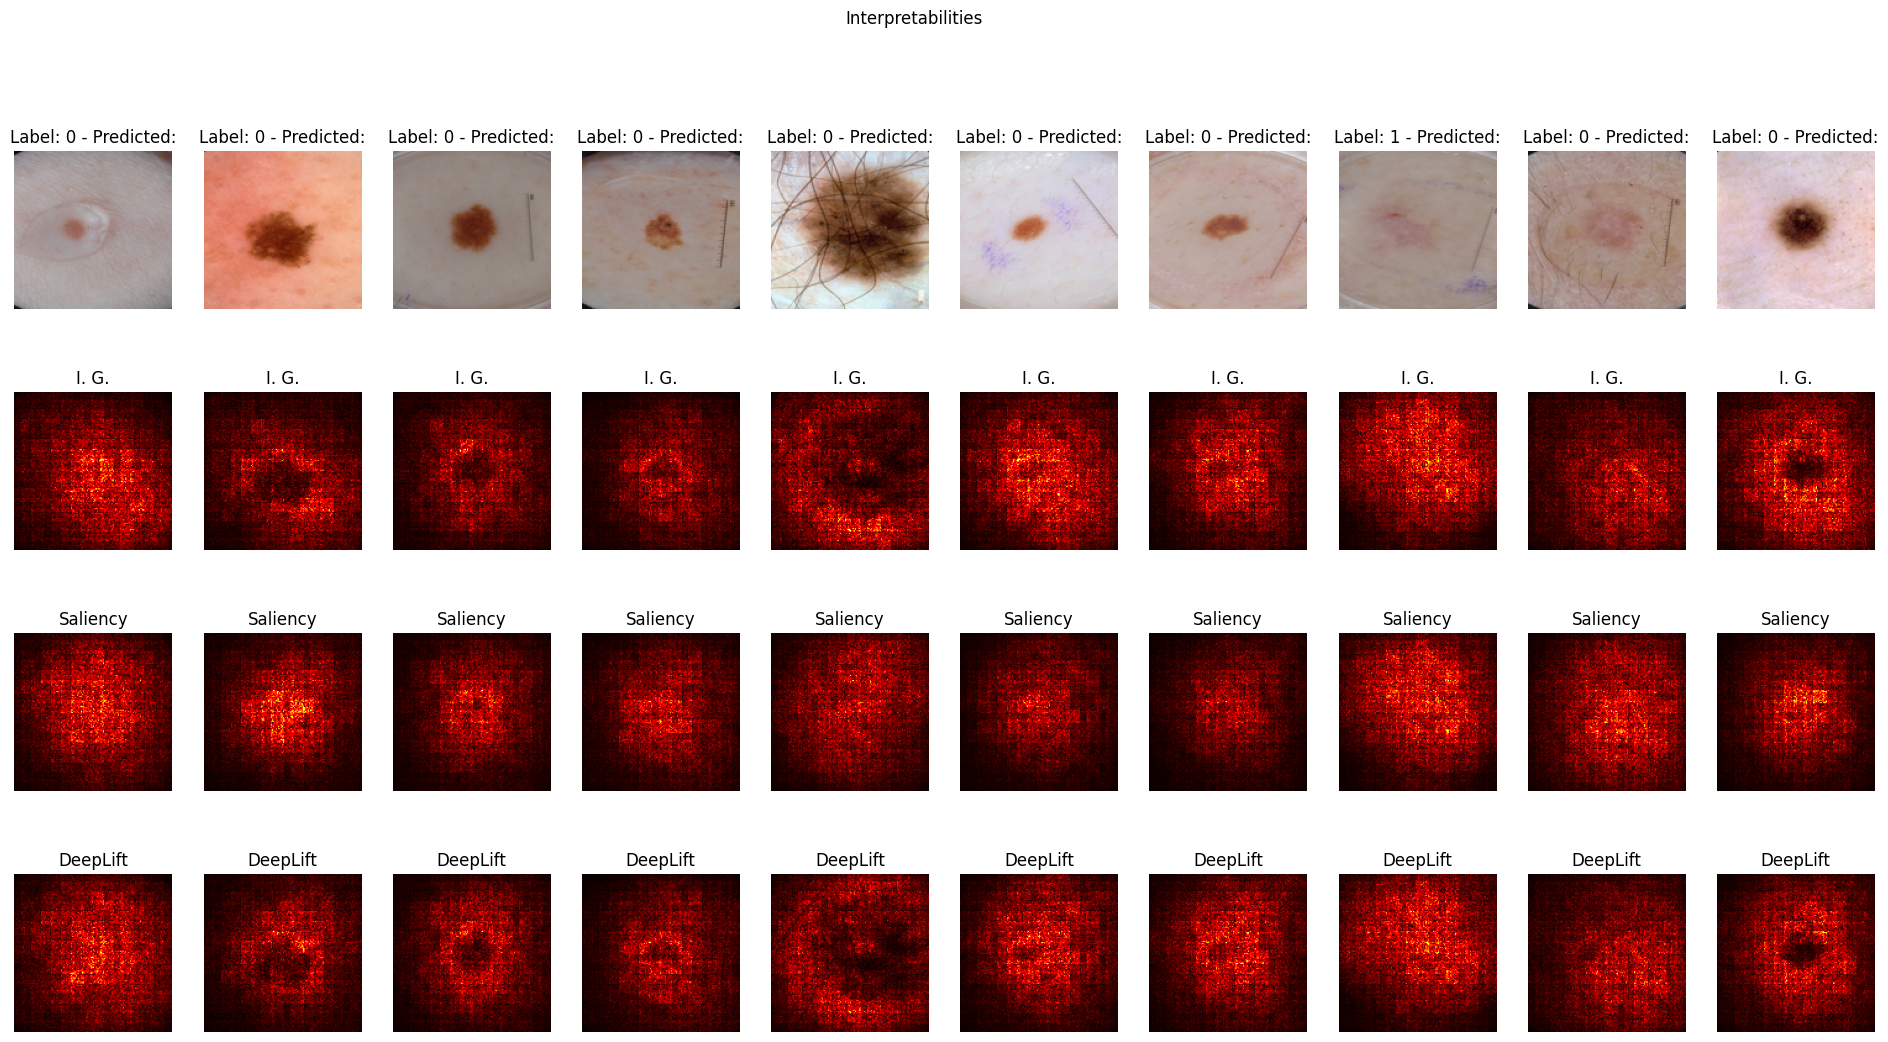

In [31]:
fig, axs = plt.subplots(4, 10, figsize=(24, 12))
i = 0
for images, ground_truth in test_loader:
    target = ground_truth.squeeze().argmax().item()
    axs[0,i].imshow(images[0].squeeze().permute(2, 1, 0))
    axs[0,i].set_title(f"Label: {target} - Predicted:")
    axs[0,i].axis("off")
    axs[1,i].imshow(interpretabilities_dict['ig'][i], cmap="hot")
    axs[1,i].set_title("I. G.")
    axs[1,i].axis("off")
    axs[2,i].imshow(interpretabilities_dict['saliency'][i], cmap="hot")
    axs[2,i].set_title("Saliency")
    axs[2,i].axis("off")
    axs[3,i].imshow(interpretabilities_dict['deep_lift'][i], cmap="hot")
    axs[3,i].set_title("DeepLift")
    axs[3,i].axis("off")
    i += 1
    if i == 10:
        break
fig.suptitle("Interpretabilities")
plt.show()

---

In [32]:
#fig, axs = plt.subplots(3, 10, figsize=(20, 10))
#for i in range(10):
#    # apply convolution filter with opencv
#    kernel = np.ones((5,5),np.float32)/25
#
#    ig = interpretabilities_dict['ig'][i]
#    ig_filtered = cv2.filter2D(ig,-1,kernel)
#    axs[0,i].imshow(ig_filtered, cmap="hot")
#    axs[0,i].set_title("I. G.")
#    axs[0,i].axis("off")
#
#    saliency = interpretabilities_dict['saliency'][i]
#    saliency_filtered = cv2.filter2D(saliency,-1,kernel)
#    axs[1,i].imshow(saliency_filtered, cmap="hot")
#    axs[1,i].set_title("Saliency")
#    axs[1,i].axis("off")
#
#    deep_lift = interpretabilities_dict['deep_lift'][i]
#    deep_lift_filtered = cv2.filter2D(deep_lift,-1,kernel)
#    axs[2,i].imshow(deep_lift_filtered, cmap="hot")
#    axs[2,i].set_title("DeepLift")
#    axs[2,i].axis("off")
#fig.suptitle("Interpretabilities convoluted")
#plt.show()

In [126]:
sam2_checkpoint = "../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [127]:
sam2_segmentations_dict = {}
sam2_segmentations_dict['ig'] = []
sam2_segmentations_dict['saliency'] = []
sam2_segmentations_dict['deep_lift'] = []
sam2_segmentations_dict['auto'] = []

In [128]:
for i in range(10):
    image = images[i].squeeze(0)
    label = labels[i]
    predictor.set_image(np.array(image.permute(1, 2, 0)))
    # Integrated Gradients prompt
    prompt_points = engineered_prompt_coordinates_dict['ig'][i]
    prompt_labels = [1] * len(prompt_points) # all foreground
    mask_ig, _, _ = predictor.predict(point_coords=prompt_points, point_labels=prompt_labels, multimask_output=False)

    # Saliency prompt
    prompt_points = engineered_prompt_coordinates_dict['saliency'][i]
    prompt_labels = [1] * len(prompt_points) # all foreground
    mask_saliency, _, _= predictor.predict(point_coords=prompt_points, point_labels=prompt_labels, multimask_output=False)

    # DeepLift prompt
    prompt_points = engineered_prompt_coordinates_dict['deep_lift'][i]
    prompt_labels = [1] * len(prompt_points) # all foreground
    mask_deep_lift, _, _ = predictor.predict(point_coords=prompt_points, point_labels=prompt_labels, multimask_output=False)

    # Auto prompt
    mask_auto, _, _ = predictor.predict(point_coords=None, point_labels=None, multimask_output=False)

    sam2_segmentations_dict['ig'].append(mask_ig)
    sam2_segmentations_dict['saliency'].append(mask_saliency)
    sam2_segmentations_dict['deep_lift'].append(mask_deep_lift)
    sam2_segmentations_dict['auto'].append(mask_auto)

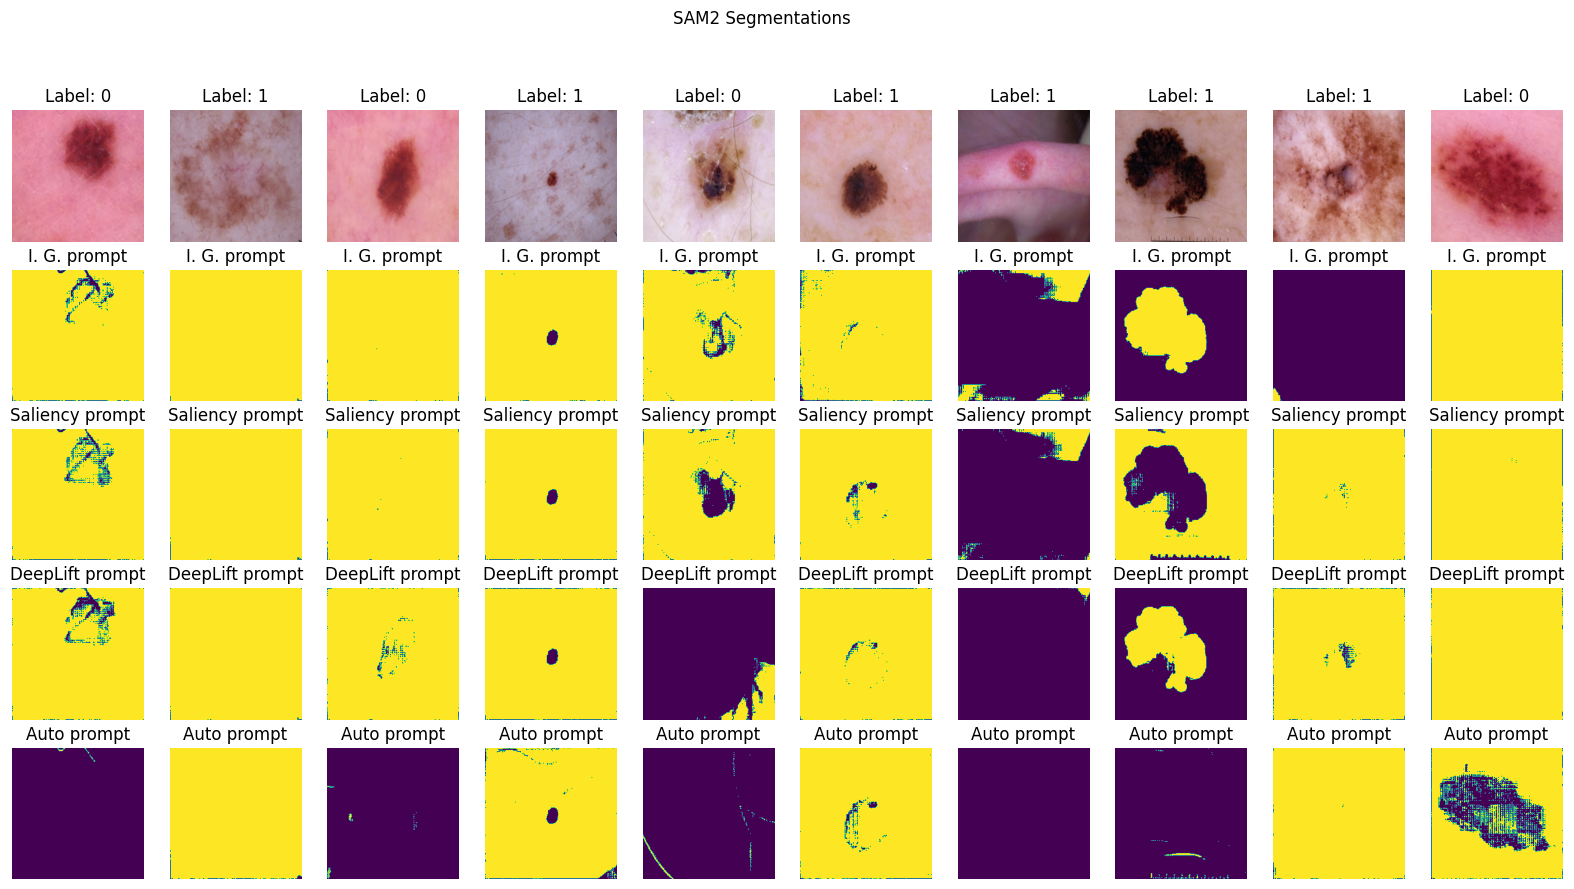

In [129]:
fig, axs = plt.subplots(5, 10, figsize=(20, 10))

for i in range(10):
    axs[0,i].imshow(images[i].squeeze().permute(1, 2, 0))
    axs[0,i].set_title(f"Label: {labels[i].item()}")
    axs[0,i].axis("off")
    axs[1,i].imshow(sam2_segmentations_dict['ig'][i].squeeze())
    axs[1,i].set_title("I. G. prompt")
    axs[1,i].axis("off")
    axs[2,i].imshow(sam2_segmentations_dict['saliency'][i].squeeze())
    axs[2,i].set_title("Saliency prompt")
    axs[2,i].axis("off")
    axs[3,i].imshow(sam2_segmentations_dict['deep_lift'][i].squeeze())
    axs[3,i].set_title("DeepLift prompt")
    axs[3,i].axis("off")
    axs[4,i].imshow(sam2_segmentations_dict['auto'][i].squeeze())
    axs[4,i].set_title("Auto prompt")
    axs[4,i].axis("off")
fig.suptitle("SAM2 Segmentations")
plt.show()